In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm
import torch

from diffusers import DDIMScheduler, DiffusionPipeline, StableDiffusionPipeline

/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Fetching 15 files: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 267721.53it/s]
/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [3]:
# These settings work for Apple M1/M2 silicon
# Docs for configuring to your hardware: https://huggingface.co/docs/diffusers/optimization/fp16
pipeline.to("mps")

# Recommended if your computer has < 64 GB of RAM
pipeline.enable_attention_slicing()

In [44]:
generator = torch.Generator().manual_seed(1024)
prompt = "a grass animal in the style of Ken Sugimori"

_ = pipeline(prompt, num_inference_steps=1) # Needed: https://github.com/huggingface/diffusers/issues/372
image = pipeline(prompt, num_inference_steps=30, generator=generator).images[0]

# TODO: https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds

100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.19it/s]


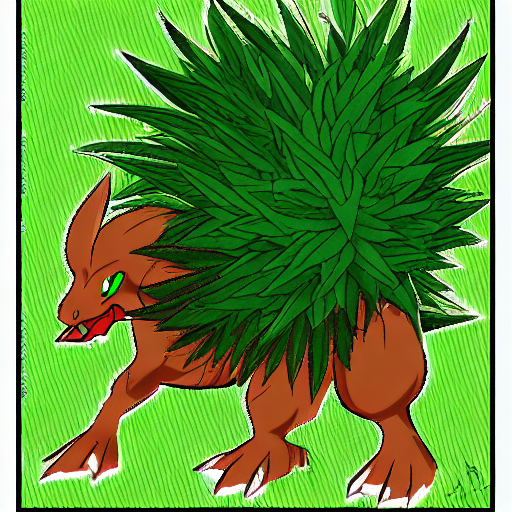

In [45]:
# imgplot = plt.imshow(images[0])
# plt.show(image)
# # image.save(f"sd-output.png")

display(image)